# Demo #10: RAG Evaluation - Systematic Metrics and Frameworks

## Overview

This notebook demonstrates how to **systematically evaluate and improve RAG systems** using quantitative metrics. We'll use the RAGAS (RAG Assessment) framework to measure performance across multiple dimensions.

### Key Concepts

1. **RAG-Specific Metrics**: Beyond traditional NLP metrics
2. **LLM-as-Judge Pattern**: Using LLMs to evaluate RAG quality
3. **Multi-Dimensional Evaluation**: Assess retrieval AND generation
4. **Iterative Improvement**: Data-driven optimization workflow

### The Four Core RAGAS Metrics

1. **Context Precision**: Are retrieved documents relevant? (measures retrieval noise)
2. **Context Recall**: Are all necessary documents retrieved? (measures retrieval completeness)
3. **Faithfulness**: Is the answer grounded in the context? (measures hallucination)
4. **Answer Relevance**: Does the answer address the question? (measures response quality)

### Why RAG Evaluation Matters

```
You can't improve what you don't measure.
```

- **Identify Bottlenecks**: Is retrieval or generation failing?
- **Compare Approaches**: Which advanced technique actually helps?
- **Monitor Production**: Detect degradation over time
- **Justify Costs**: Prove that improvements are worth the investment

### Citations

- **RAG Evaluation Metrics Guide** - Reference #84
- **RAGAS Framework** - Reference #89
- **A complete guide to RAG evaluation** - Evidently AI

## 1. Setup and Imports

In [6]:
# uv pip install llama-index-llms-azure-openai llama-index-embeddings-azure-openai matplotlib langchain-openai

import os
import sys
from pathlib import Path
from typing import List, Dict

# Data handling
import pandas as pd
import numpy as np

# LlamaIndex for RAG
from llama_index.core import (
    VectorStoreIndex,
    SimpleDirectoryReader,
    Settings,
)
from llama_index.core.node_parser import SentenceSplitter
from llama_index.llms.azure_openai import AzureOpenAI
from llama_index.embeddings.azure_openai import AzureOpenAIEmbedding

# RAGAS for evaluation
from ragas import evaluate
from ragas.metrics import (
    context_precision,
    context_recall,
    faithfulness,
    answer_relevancy,
)
from datasets import Dataset

# Utilities
from dotenv import load_dotenv
import warnings
warnings.filterwarnings('ignore')

load_dotenv()
# Verify environment variables
api_key = os.getenv("AZURE_OPENAI_API_KEY")
azure_endpoint = os.getenv("AZURE_OPENAI_ENDPOINT")
api_version = os.getenv("AZURE_OPENAI_API_VERSION")


if not api_key or not azure_endpoint or not api_version:
    print("❌ Please set your Azure OpenAI credentials in the .env file.")
    sys.exit(1)
else:
    print(f"endpoint: {azure_endpoint}, api_version: {api_version}")
    print(f"api_key: {'*' * (len(api_key) - 4) + api_key[-4:]}")  # Print only last 4 chars

print("✓ All imports successful")

endpoint: https://aoai-sweden-505.openai.azure.com/, api_version: 2024-12-01-preview
api_key: ********************************************************************************3zxB
✓ All imports successful


## 2. Configure Azure OpenAI

In [7]:
# Azure OpenAI Configuration

# Initialize LLM
llm = AzureOpenAI(
    model="gpt-4o",
    deployment_name=os.getenv("AZURE_OPENAI_DEPLOYMENT_NAME"),
    api_key=api_key,
    azure_endpoint=azure_endpoint,
    api_version=api_version,
    temperature=0.1,
)

# Initialize Embedding Model
embed_model = AzureOpenAIEmbedding(
    model="text-embedding-ada-002",
    deployment_name=os.getenv("AZURE_OPENAI_EMBEDDING_DEPLOYMENT"),
    api_key=api_key,
    azure_endpoint=azure_endpoint,
    api_version=api_version,
)

# Test the models (optional - comment out if you want to skip testing)
try:
    response = llm.complete("Hello, world!")
    print("LLM response:", response.text)
    embedding = embed_model.get_text_embedding("Hello, world!")
    print("Embedding response:", embedding[:5], "...")  # Print first 5 dimensions
except Exception as e:
    print(f"⚠️  Model test skipped: {e}")
    print("Continuing with configuration...")

# Configure global settings
Settings.llm = llm
Settings.embed_model = embed_model
Settings.chunk_size = 512
Settings.chunk_overlap = 50

print("✓ Azure OpenAI configured successfully")

LLM response: Hello! How can I assist you today?
Embedding response: [0.001459865947254002, 0.003402094589546323, -0.013020599260926247, -0.03340122103691101, -0.009493920020759106] ...
Embedding response: [0.001459865947254002, 0.003402094589546323, -0.013020599260926247, -0.03340122103691101, -0.009493920020759106] ...
✓ Azure OpenAI configured successfully
✓ Azure OpenAI configured successfully


## 3. Build RAG System

Create a standard RAG system that we'll evaluate.

In [8]:
# Load ML concepts documents
data_path = Path("../RAG_v2/data/ml_concepts")
documents = SimpleDirectoryReader(str(data_path)).load_data()

print(f"✓ Loaded {len(documents)} documents")

# Parse into chunks
node_parser = SentenceSplitter(chunk_size=512, chunk_overlap=50)
nodes = node_parser.get_nodes_from_documents(documents)

print(f"✓ Created {len(nodes)} chunks")

# Build vector index
index = VectorStoreIndex(
    nodes=nodes,
    embed_model=embed_model,
)

# Create query engine
query_engine = index.as_query_engine(
    similarity_top_k=3,
    llm=llm,
)

print("✓ RAG system ready for evaluation")

✓ Loaded 5 documents
✓ Created 8 chunks
✓ Created 8 chunks


2025-10-16 14:03:04,904 - INFO - HTTP Request: POST https://aoai-sweden-505.openai.azure.com/openai/deployments/text-embedding-ada-002/embeddings?api-version=2024-12-01-preview "HTTP/1.1 200 OK"


✓ RAG system ready for evaluation


## 4. Create Evaluation Test Set

Define questions with ground truth answers and expected context.

In [9]:
# Test questions about ML concepts
test_questions = [
    {
        "question": "What is gradient boosting and how does it work?",
        "ground_truth": "Gradient boosting is an ensemble learning technique that builds models sequentially, where each new model corrects the errors of the previous ones. It combines weak learners (typically decision trees) to create a strong predictive model by optimizing a loss function through gradient descent.",
        "ground_truth_context": "gradient_boosting.md",
    },
    {
        "question": "Explain how K-means clustering algorithm works.",
        "ground_truth": "K-means clustering is an unsupervised learning algorithm that partitions data into K clusters by iteratively assigning points to the nearest centroid and updating centroids based on the mean of assigned points. It minimizes within-cluster variance.",
        "ground_truth_context": "kmeans_clustering.md",
    },
    {
        "question": "What are neural networks and how do they learn?",
        "ground_truth": "Neural networks are computational models inspired by biological neural networks, consisting of layers of interconnected nodes (neurons). They learn through backpropagation, adjusting weights based on the error between predicted and actual outputs to minimize a loss function.",
        "ground_truth_context": "neural_networks.md",
    },
    {
        "question": "How do random forests improve upon single decision trees?",
        "ground_truth": "Random forests improve upon single decision trees by creating an ensemble of multiple decision trees trained on random subsets of data and features. This reduces overfitting and variance through bootstrap aggregating (bagging) and averaging predictions.",
        "ground_truth_context": "random_forests.md",
    },
    {
        "question": "What is the kernel trick in Support Vector Machines?",
        "ground_truth": "The kernel trick in SVMs allows the algorithm to operate in a high-dimensional feature space without explicitly computing coordinates in that space. It uses kernel functions to implicitly map data to higher dimensions where it becomes linearly separable.",
        "ground_truth_context": "support_vector_machines.md",
    },
    {
        "question": "Compare gradient boosting with random forests in terms of bias and variance.",
        "ground_truth": "Gradient boosting reduces bias by sequentially correcting errors, making it powerful but prone to overfitting (high variance). Random forests reduce variance through ensemble averaging but may have higher bias. Gradient boosting typically achieves better accuracy but requires more careful tuning.",
        "ground_truth_context": "gradient_boosting.md, random_forests.md",
    },
]

print(f"✓ Created test set with {len(test_questions)} questions")
print("\nSample question:")
print(f"Q: {test_questions[0]['question']}")
print(f"Ground Truth: {test_questions[0]['ground_truth'][:100]}...")

✓ Created test set with 6 questions

Sample question:
Q: What is gradient boosting and how does it work?
Ground Truth: Gradient boosting is an ensemble learning technique that builds models sequentially, where each new ...


## 5. Run RAG System and Collect Data

Execute each test question and collect: question, answer, contexts.

In [10]:
# Collect RAG outputs
evaluation_data = []

print("Running RAG system on test questions...\n")

for i, test in enumerate(test_questions, 1):
    question = test["question"]
    print(f"[{i}/{len(test_questions)}] Processing: {question[:60]}...")
    
    # Query RAG system
    response = query_engine.query(question)
    
    # Extract retrieved contexts
    contexts = [node.node.text for node in response.source_nodes]
    
    # Store data
    evaluation_data.append({
        "question": question,
        "answer": response.response,
        "contexts": contexts,
        "ground_truth": test["ground_truth"],
    })

print(f"\n✓ Collected {len(evaluation_data)} RAG outputs")

# Display sample
print(f"\nSample RAG Output:")
print(f"Question: {evaluation_data[0]['question']}")
print(f"Answer: {evaluation_data[0]['answer'][:200]}...")
print(f"Retrieved {len(evaluation_data[0]['contexts'])} context chunks")

2025-10-16 14:03:09,677 - INFO - HTTP Request: POST https://aoai-sweden-505.openai.azure.com/openai/deployments/text-embedding-ada-002/embeddings?api-version=2024-12-01-preview "HTTP/1.1 200 OK"


Running RAG system on test questions...

[1/6] Processing: What is gradient boosting and how does it work?...


2025-10-16 14:03:10,876 - INFO - HTTP Request: POST https://aoai-sweden-505.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version=2024-12-01-preview "HTTP/1.1 200 OK"
2025-10-16 14:03:10,974 - INFO - HTTP Request: POST https://aoai-sweden-505.openai.azure.com/openai/deployments/text-embedding-ada-002/embeddings?api-version=2024-12-01-preview "HTTP/1.1 200 OK"
2025-10-16 14:03:10,974 - INFO - HTTP Request: POST https://aoai-sweden-505.openai.azure.com/openai/deployments/text-embedding-ada-002/embeddings?api-version=2024-12-01-preview "HTTP/1.1 200 OK"


[2/6] Processing: Explain how K-means clustering algorithm works....


2025-10-16 14:03:12,424 - INFO - HTTP Request: POST https://aoai-sweden-505.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version=2024-12-01-preview "HTTP/1.1 200 OK"
2025-10-16 14:03:12,515 - INFO - HTTP Request: POST https://aoai-sweden-505.openai.azure.com/openai/deployments/text-embedding-ada-002/embeddings?api-version=2024-12-01-preview "HTTP/1.1 200 OK"
2025-10-16 14:03:12,515 - INFO - HTTP Request: POST https://aoai-sweden-505.openai.azure.com/openai/deployments/text-embedding-ada-002/embeddings?api-version=2024-12-01-preview "HTTP/1.1 200 OK"


[3/6] Processing: What are neural networks and how do they learn?...


2025-10-16 14:03:13,339 - INFO - HTTP Request: POST https://aoai-sweden-505.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version=2024-12-01-preview "HTTP/1.1 200 OK"
2025-10-16 14:03:13,429 - INFO - HTTP Request: POST https://aoai-sweden-505.openai.azure.com/openai/deployments/text-embedding-ada-002/embeddings?api-version=2024-12-01-preview "HTTP/1.1 200 OK"
2025-10-16 14:03:13,429 - INFO - HTTP Request: POST https://aoai-sweden-505.openai.azure.com/openai/deployments/text-embedding-ada-002/embeddings?api-version=2024-12-01-preview "HTTP/1.1 200 OK"


[4/6] Processing: How do random forests improve upon single decision trees?...


2025-10-16 14:03:14,388 - INFO - HTTP Request: POST https://aoai-sweden-505.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version=2024-12-01-preview "HTTP/1.1 200 OK"
2025-10-16 14:03:14,487 - INFO - HTTP Request: POST https://aoai-sweden-505.openai.azure.com/openai/deployments/text-embedding-ada-002/embeddings?api-version=2024-12-01-preview "HTTP/1.1 200 OK"
2025-10-16 14:03:14,487 - INFO - HTTP Request: POST https://aoai-sweden-505.openai.azure.com/openai/deployments/text-embedding-ada-002/embeddings?api-version=2024-12-01-preview "HTTP/1.1 200 OK"


[5/6] Processing: What is the kernel trick in Support Vector Machines?...


2025-10-16 14:03:15,838 - INFO - HTTP Request: POST https://aoai-sweden-505.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version=2024-12-01-preview "HTTP/1.1 200 OK"
2025-10-16 14:03:15,924 - INFO - HTTP Request: POST https://aoai-sweden-505.openai.azure.com/openai/deployments/text-embedding-ada-002/embeddings?api-version=2024-12-01-preview "HTTP/1.1 200 OK"
2025-10-16 14:03:15,924 - INFO - HTTP Request: POST https://aoai-sweden-505.openai.azure.com/openai/deployments/text-embedding-ada-002/embeddings?api-version=2024-12-01-preview "HTTP/1.1 200 OK"


[6/6] Processing: Compare gradient boosting with random forests in terms of bi...


2025-10-16 14:03:17,384 - INFO - HTTP Request: POST https://aoai-sweden-505.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version=2024-12-01-preview "HTTP/1.1 200 OK"



✓ Collected 6 RAG outputs

Sample RAG Output:
Question: What is gradient boosting and how does it work?
Answer: Gradient Boosting is an ensemble machine learning technique that constructs a strong predictive model by combining multiple weak learners, typically decision trees, in a sequential manner. The process...
Retrieved 3 context chunks


## 6. Prepare Data for RAGAS

Convert to Hugging Face Dataset format.

In [11]:
# Convert to Hugging Face Dataset
eval_dataset = Dataset.from_dict({
    "question": [d["question"] for d in evaluation_data],
    "answer": [d["answer"] for d in evaluation_data],
    "contexts": [d["contexts"] for d in evaluation_data],
    "ground_truth": [d["ground_truth"] for d in evaluation_data],
})

print("✓ Dataset prepared for RAGAS evaluation")
print(f"\nDataset structure:")
print(eval_dataset)

✓ Dataset prepared for RAGAS evaluation

Dataset structure:
Dataset({
    features: ['question', 'answer', 'contexts', 'ground_truth'],
    num_rows: 6
})


## 7. Configure RAGAS with Azure OpenAI

RAGAS uses LLM-as-judge, so we need to configure it with our Azure OpenAI LLM.

In [12]:
# Import LangChain wrappers for RAGAS
from langchain_openai import AzureChatOpenAI, AzureOpenAIEmbeddings

# Create LangChain-compatible LLM for RAGAS
ragas_llm = AzureChatOpenAI(
    openai_api_version=api_version,
    azure_endpoint=azure_endpoint,
    azure_deployment=os.getenv("AZURE_OPENAI_DEPLOYMENT_NAME"),
    api_key=api_key,
    temperature=0.1,
)

# Create LangChain-compatible embeddings for RAGAS
ragas_embeddings = AzureOpenAIEmbeddings(
    openai_api_version=api_version,
    azure_endpoint=azure_endpoint,
    azure_deployment=os.getenv("AZURE_OPENAI_EMBEDDING_DEPLOYMENT"),
    api_key=api_key,
)

print("✓ RAGAS configured with Azure OpenAI")

✓ RAGAS configured with Azure OpenAI


## 8. Run RAGAS Evaluation

Calculate all four core metrics.

In [13]:
print("\n" + "="*80)
print("RUNNING RAGAS EVALUATION")
print("="*80)
print("\nThis may take a few minutes as each metric requires LLM evaluation...\n")

# Run evaluation
result = evaluate(
    eval_dataset,
    metrics=[
        context_precision,
        context_recall,
        faithfulness,
        answer_relevancy,
    ],
    llm=ragas_llm,
    embeddings=ragas_embeddings,
)

print("\n✓ Evaluation complete")


RUNNING RAGAS EVALUATION

This may take a few minutes as each metric requires LLM evaluation...



Evaluating:   0%|          | 0/24 [00:00<?, ?it/s]

2025-10-16 14:03:19,013 - INFO - HTTP Request: POST https://aoai-sweden-505.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version=2024-12-01-preview "HTTP/1.1 200 OK"
2025-10-16 14:03:19,019 - INFO - HTTP Request: POST https://aoai-sweden-505.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version=2024-12-01-preview "HTTP/1.1 200 OK"
2025-10-16 14:03:19,019 - INFO - HTTP Request: POST https://aoai-sweden-505.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version=2024-12-01-preview "HTTP/1.1 200 OK"
2025-10-16 14:03:20,338 - INFO - HTTP Request: POST https://aoai-sweden-505.openai.azure.com/openai/deployments/text-embedding-ada-002/embeddings?api-version=2024-12-01-preview "HTTP/1.1 200 OK"
2025-10-16 14:03:20,338 - INFO - HTTP Request: POST https://aoai-sweden-505.openai.azure.com/openai/deployments/text-embedding-ada-002/embeddings?api-version=2024-12-01-preview "HTTP/1.1 200 OK"
2025-10-16 14:03:20,924 - INFO - HTTP Request: POST htt


✓ Evaluation complete


## 9. Display Overall Results

In [14]:
# Convert results to DataFrame
results_df = result.to_pandas()

# Display aggregate metrics
print("\n" + "="*80)
print("RAGAS EVALUATION RESULTS")
print("="*80)
print("\nAggregate Scores (0.0 - 1.0):")
print("-" * 80)

metrics_summary = {
    "Context Precision": results_df["context_precision"].mean(),
    "Context Recall": results_df["context_recall"].mean(),
    "Faithfulness": results_df["faithfulness"].mean(),
    "Answer Relevancy": results_df["answer_relevancy"].mean(),
}

for metric, score in metrics_summary.items():
    print(f"{metric:.<40} {score:.3f}")

print("\n" + "="*80)

# Overall RAG Score (average of all metrics)
overall_score = sum(metrics_summary.values()) / len(metrics_summary)
print(f"\nOverall RAG Score: {overall_score:.3f}")
print("="*80)


RAGAS EVALUATION RESULTS

Aggregate Scores (0.0 - 1.0):
--------------------------------------------------------------------------------
Context Precision....................... 0.833
Context Recall.......................... 0.944
Faithfulness............................ 0.934
Answer Relevancy........................ 0.967


Overall RAG Score: 0.920


## 10. Analyze Per-Question Results

Identify which questions performed poorly and why.

In [17]:
results_df

,user_input,retrieved_contexts,response,reference,context_precision,context_recall,faithfulness,answer_relevancy
0,What is gradient boosting and how does it work?,[# Gradient Boosting\n\nGradient Boosting is a...,Gradient Boosting is an ensemble machine learn...,Gradient boosting is an ensemble learning tech...,1.0,1.000000,1.000000,0.952050
1,Explain how K-means clustering algorithm works.,[# K-Means Clustering\n\nK-Means is an unsuper...,K-Means clustering is an unsupervised learning...,K-means clustering is an unsupervised learning...,1.0,1.000000,1.000000,0.939778
2,What are neural networks and how do they learn?,[# Neural Networks\n\nNeural Networks are comp...,Neural networks are computational models inspi...,Neural networks are computational models inspi...,1.0,1.000000,1.000000,0.950966
3,How do random forests improve upon single deci...,[# Random Forests\n\nRandom Forest is an ensem...,Random forests improve upon single decision tr...,Random forests improve upon single decision tr...,1.0,1.000000,0.875000,0.999958
4,What is the kernel trick in Support Vector Mac...,[# Support Vector Machines (SVM)\n\nSupport Ve...,The kernel trick in Support Vector Machines is...,The kernel trick in SVMs allows the algorithm ...,1.0,1.000000,1.000000,0.999999
5,Compare gradient boosting with random forests ...,[# Random Forests\n\nRandom Forest is an ensem...,Gradient boosting and random forests differ in...,Gradient boosting reduces bias by sequentially...,0.0,0.666667,0.727273,0.962199


In [18]:
# Display per-question scores
print("\n" + "="*80)
print("PER-QUESTION ANALYSIS")
print("="*80)

# Add question summary
results_df["question_short"] = results_df["user_input"].str[:50] + "..."

# Select relevant columns
analysis_df = results_df[[
    "question_short",
    "context_precision",
    "context_recall",
    "faithfulness",
    "answer_relevancy",
]].copy()

# Format scores
for col in ["context_precision", "context_recall", "faithfulness", "answer_relevancy"]:
    analysis_df[col] = analysis_df[col].apply(lambda x: f"{x:.3f}")

print("\n" + analysis_df.to_string(index=False))
print("\n" + "="*80)


PER-QUESTION ANALYSIS

                                       question_short context_precision context_recall faithfulness answer_relevancy
   What is gradient boosting and how does it work?...             1.000          1.000        1.000            0.952
   Explain how K-means clustering algorithm works....             1.000          1.000        1.000            0.940
   What are neural networks and how do they learn?...             1.000          1.000        1.000            0.951
How do random forests improve upon single decision...             1.000          1.000        0.875            1.000
What is the kernel trick in Support Vector Machine...             1.000          1.000        1.000            1.000
Compare gradient boosting with random forests in t...             0.000          0.667        0.727            0.962



## 11. Identify Failure Modes

Diagnose bottlenecks based on metric patterns.

In [19]:
print("\n" + "="*80)
print("FAILURE MODE ANALYSIS")
print("="*80)

# Define thresholds
threshold = 0.7

# Analyze each metric
print("\n📊 Diagnostic Insights:\n")

# Context Precision issues
low_precision = results_df[results_df["context_precision"] < threshold]
if len(low_precision) > 0:
    print(f"⚠️  Low Context Precision ({len(low_precision)} questions):")
    print("   → Too much irrelevant information in retrieval")
    print("   → Solution: Add re-ranker, improve chunking, or use hybrid search")
    print()

# Context Recall issues
low_recall = results_df[results_df["context_recall"] < threshold]
if len(low_recall) > 0:
    print(f"⚠️  Low Context Recall ({len(low_recall)} questions):")
    print("   → Missing relevant documents in retrieval")
    print("   → Solution: Increase top-k, use query expansion, or improve embeddings")
    print()

# Faithfulness issues
low_faithfulness = results_df[results_df["faithfulness"] < threshold]
if len(low_faithfulness) > 0:
    print(f"⚠️  Low Faithfulness ({len(low_faithfulness)} questions):")
    print("   → LLM hallucinating or adding unsupported facts")
    print("   → Solution: Improve prompting, fine-tune LLM, or use stricter grounding")
    print()

# Answer Relevancy issues
low_relevancy = results_df[results_df["answer_relevancy"] < threshold]
if len(low_relevancy) > 0:
    print(f"⚠️  Low Answer Relevancy ({len(low_relevancy)} questions):")
    print("   → Answers not addressing the question properly")
    print("   → Solution: Improve prompt engineering or query understanding")
    print()

if (len(low_precision) + len(low_recall) + len(low_faithfulness) + len(low_relevancy)) == 0:
    print("✅ All metrics above threshold! RAG system performing well.")

print("\n" + "="*80)


FAILURE MODE ANALYSIS

📊 Diagnostic Insights:

⚠️  Low Context Precision (1 questions):
   → Too much irrelevant information in retrieval
   → Solution: Add re-ranker, improve chunking, or use hybrid search

⚠️  Low Context Recall (1 questions):
   → Missing relevant documents in retrieval
   → Solution: Increase top-k, use query expansion, or improve embeddings




## 12. Visualize Results

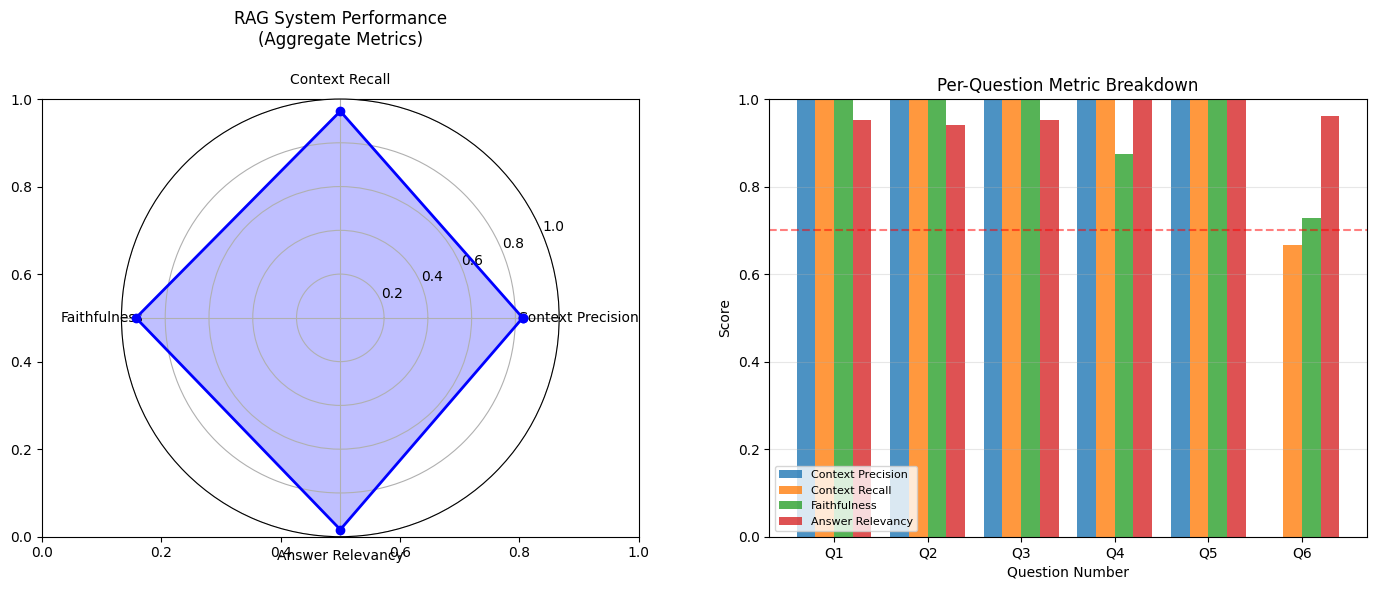

✓ Visualization saved as: rag_evaluation_results.png


In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Create radar chart for aggregate metrics
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Radar chart
categories = list(metrics_summary.keys())
values = list(metrics_summary.values())
values += values[:1]  # Close the circle

angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist()
angles += angles[:1]

ax1 = plt.subplot(121, projection='polar')
ax1.plot(angles, values, 'o-', linewidth=2, color='blue')
ax1.fill(angles, values, alpha=0.25, color='blue')
ax1.set_xticks(angles[:-1])
ax1.set_xticklabels(categories, size=10)
ax1.set_ylim(0, 1)
ax1.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
ax1.set_title("RAG System Performance\n(Aggregate Metrics)", size=12, pad=20)
ax1.grid(True)

# Bar chart for per-question scores
ax2 = plt.subplot(122)
x = np.arange(len(results_df))
width = 0.2

ax2.bar(x - 1.5*width, results_df["context_precision"], width, label='Context Precision', alpha=0.8)
ax2.bar(x - 0.5*width, results_df["context_recall"], width, label='Context Recall', alpha=0.8)
ax2.bar(x + 0.5*width, results_df["faithfulness"], width, label='Faithfulness', alpha=0.8)
ax2.bar(x + 1.5*width, results_df["answer_relevancy"], width, label='Answer Relevancy', alpha=0.8)

ax2.set_xlabel('Question Number')
ax2.set_ylabel('Score')
ax2.set_title('Per-Question Metric Breakdown')
ax2.set_xticks(x)
ax2.set_xticklabels([f"Q{i+1}" for i in range(len(results_df))])
ax2.legend(loc='lower left', fontsize=8)
ax2.set_ylim(0, 1)
ax2.grid(True, alpha=0.3, axis='y')
ax2.axhline(y=0.7, color='r', linestyle='--', alpha=0.5, label='Threshold')

plt.tight_layout()
plt.savefig('rag_evaluation_results.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Visualization saved as: rag_evaluation_results.png")

## 13. Simulate Iterative Improvement

Show how to apply improvements based on evaluation results.

In [21]:
print("\n" + "="*80)
print("ITERATIVE IMPROVEMENT WORKFLOW")
print("="*80)

print("\n📋 Recommended Improvements Based on Evaluation:\n")

# Determine primary bottleneck
avg_precision = results_df["context_precision"].mean()
avg_recall = results_df["context_recall"].mean()
avg_faithfulness = results_df["faithfulness"].mean()
avg_relevancy = results_df["answer_relevancy"].mean()

bottlenecks = [
    ("Context Precision", avg_precision),
    ("Context Recall", avg_recall),
    ("Faithfulness", avg_faithfulness),
    ("Answer Relevancy", avg_relevancy),
]

# Sort by score (lowest first)
bottlenecks.sort(key=lambda x: x[1])

print(f"1️⃣  Primary Bottleneck: {bottlenecks[0][0]} (Score: {bottlenecks[0][1]:.3f})")

# Provide specific recommendations
if bottlenecks[0][0] == "Context Precision":
    print("\n   📌 Recommended Actions:")
    print("      • Implement re-ranking (Demo #5) to filter irrelevant results")
    print("      • Use context compression (Demo #6) to remove noise")
    print("      • Improve chunking strategy (Demo #4) for better granularity")
    print("      • Add hybrid search (Demo #3) for better exact matching")

elif bottlenecks[0][0] == "Context Recall":
    print("\n   📌 Recommended Actions:")
    print("      • Increase similarity_top_k from 3 to 5 or higher")
    print("      • Use query expansion (Demo #2) to find more relevant docs")
    print("      • Apply HyDE (Demo #1) for better semantic matching")
    print("      • Fine-tune embeddings (Demo #9) for domain adaptation")

elif bottlenecks[0][0] == "Faithfulness":
    print("\n   📌 Recommended Actions:")
    print("      • Improve system prompt to emphasize grounding")
    print("      • Use lower temperature (more deterministic)")
    print("      • Implement CRAG (Demo #7) for self-correction")
    print("      • Consider fine-tuning the generator LLM")

elif bottlenecks[0][0] == "Answer Relevancy":
    print("\n   📌 Recommended Actions:")
    print("      • Refine prompt engineering for better instruction following")
    print("      • Use multi-query decomposition (Demo #2) for complex questions")
    print("      • Implement agentic RAG (Demo #8) for adaptive reasoning")

print("\n" + "="*80)
print("\n💡 Next Steps:")
print("   1. Apply recommended improvement")
print("   2. Re-run evaluation on same test set")
print("   3. Compare before/after metrics")
print("   4. Iterate until target performance achieved")
print("\n" + "="*80)


ITERATIVE IMPROVEMENT WORKFLOW

📋 Recommended Improvements Based on Evaluation:

1️⃣  Primary Bottleneck: Context Precision (Score: 0.833)

   📌 Recommended Actions:
      • Implement re-ranking (Demo #5) to filter irrelevant results
      • Use context compression (Demo #6) to remove noise
      • Improve chunking strategy (Demo #4) for better granularity
      • Add hybrid search (Demo #3) for better exact matching


💡 Next Steps:
   1. Apply recommended improvement
   2. Re-run evaluation on same test set
   3. Compare before/after metrics
   4. Iterate until target performance achieved



## 14. Export Results for Reporting

In [22]:
# Save detailed results to CSV
results_df.to_csv("rag_evaluation_detailed.csv", index=False)
print("✓ Detailed results saved to: rag_evaluation_detailed.csv")

# Save summary report
summary_report = f"""
RAG SYSTEM EVALUATION REPORT
============================

Evaluation Date: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}
Test Questions: {len(test_questions)}

AGGREGATE METRICS
-----------------
Context Precision:  {avg_precision:.3f}
Context Recall:     {avg_recall:.3f}
Faithfulness:       {avg_faithfulness:.3f}
Answer Relevancy:   {avg_relevancy:.3f}

Overall Score:      {overall_score:.3f}

PRIMARY BOTTLENECK
------------------
{bottlenecks[0][0]}: {bottlenecks[0][1]:.3f}

QUESTIONS BELOW THRESHOLD (0.7)
--------------------------------
Low Context Precision:  {len(low_precision)}
Low Context Recall:     {len(low_recall)}
Low Faithfulness:       {len(low_faithfulness)}
Low Answer Relevancy:   {len(low_relevancy)}

See rag_evaluation_detailed.csv for per-question analysis.
"""

with open("rag_evaluation_summary.txt", "w") as f:
    f.write(summary_report)

print("✓ Summary report saved to: rag_evaluation_summary.txt")
print("\n" + summary_report)

✓ Detailed results saved to: rag_evaluation_detailed.csv
✓ Summary report saved to: rag_evaluation_summary.txt


RAG SYSTEM EVALUATION REPORT

Evaluation Date: 2025-10-16 14:15:02
Test Questions: 6

AGGREGATE METRICS
-----------------
Context Precision:  0.833
Context Recall:     0.944
Faithfulness:       0.934
Answer Relevancy:   0.967

Overall Score:      0.920

PRIMARY BOTTLENECK
------------------
Context Precision: 0.833

QUESTIONS BELOW THRESHOLD (0.7)
--------------------------------
Low Context Precision:  1
Low Context Recall:     1
Low Faithfulness:       0
Low Answer Relevancy:   0

See rag_evaluation_detailed.csv for per-question analysis.



## 15. Key Takeaways

### The Four RAGAS Metrics Explained

1. **Context Precision** (0-1): 
   - Measures: What % of retrieved documents are actually relevant?
   - Low score means: Too much noise in retrieval
   - Fix with: Re-ranking, better chunking, hybrid search

2. **Context Recall** (0-1):
   - Measures: What % of relevant documents were retrieved?
   - Low score means: Missing critical information
   - Fix with: Higher top-k, query expansion, better embeddings

3. **Faithfulness** (0-1):
   - Measures: Is the answer supported by retrieved context?
   - Low score means: LLM is hallucinating
   - Fix with: Better prompting, stricter grounding, fine-tuning

4. **Answer Relevancy** (0-1):
   - Measures: Does the answer actually address the question?
   - Low score means: Answers are off-topic
   - Fix with: Prompt engineering, query understanding

### LLM-as-Judge Pattern

RAGAS uses LLMs to evaluate RAG outputs because:
- Traditional metrics (BLEU, ROUGE) don't capture semantic quality
- Human evaluation is expensive and slow
- LLMs can assess relevance, faithfulness, and coherence

**Trade-off**: LLM evaluation adds cost and latency but provides nuanced insights.

### Evaluation-Driven Development Workflow

```
1. Build baseline RAG system
2. Create test set with ground truth
3. Run evaluation (RAGAS)
4. Identify bottleneck (lowest metric)
5. Apply targeted improvement
6. Re-evaluate and compare
7. Repeat until target performance
```

### When to Evaluate

✅ **Critical Moments**:
- Before deploying to production
- After major architecture changes
- When adding new data sources
- Regular monitoring (weekly/monthly)
- After user complaints spike

### Production Evaluation Strategy

1. **Offline Evaluation** (what we did here):
   - Fixed test set with ground truth
   - Comprehensive metrics
   - Compare different approaches

2. **Online Evaluation** (production):
   - User feedback (thumbs up/down)
   - Click-through rates
   - Session abandonment
   - Response time monitoring

3. **Hybrid Approach**:
   - Automated offline evaluation weekly
   - Sample online queries for manual review
   - A/B testing for major changes

### Alternative Evaluation Frameworks

- **TruLens**: Real-time evaluation with feedback functions
- **DeepEval**: Unit testing for LLM applications
- **LangSmith**: LangChain's evaluation and observability
- **Phoenix**: Arize's LLM observability platform
- **Manual Evaluation**: Gold standard but expensive

### Cost Considerations

RAGAS evaluation costs:
- **Per Question**: ~3-5 LLM calls (one per metric)
- **For 100 questions**: ~400-500 API calls
- **Estimated Cost**: $1-5 for GPT-4 (varies by model)

**Optimization**:
- Use smaller test set for rapid iteration (10-20 questions)
- Full evaluation before major releases
- Cache evaluation results
- Use cheaper models for context metrics (GPT-3.5)

## 16. Metric Formulas and Calculation Details

### Context Precision

$$
\text{Context Precision} = \frac{\sum_{k=1}^{K} (\text{Precision@k} \times v_k)}{\text{Total Relevant in Top-K}}
$$

Where $v_k$ is 1 if the chunk at rank $k$ is relevant, 0 otherwise.

### Context Recall

$$
\text{Context Recall} = \frac{|\text{GT sentences in retrieved context}|}{|\text{Total GT sentences}|}
$$

Measures how many ground truth sentences appear in retrieved chunks.

### Faithfulness

$$
\text{Faithfulness} = \frac{|\text{Supported claims}|}{|\text{Total claims}|}
$$

LLM extracts claims from answer and verifies each against context.

### Answer Relevancy

$$
\text{Answer Relevancy} = \frac{1}{N} \sum_{i=1}^{N} \text{sim}(q, q'_i)
$$

Where $q'_i$ are generated questions from the answer, and $q$ is original question.

## References

1. **RAG Evaluation Metrics Guide** - Future AGI (Reference #84)
   - Link: https://futureagi.com/blogs/rag-evaluation-metrics-2025

2. **A complete guide to RAG evaluation** - Evidently AI (Reference #85)
   - Link: https://www.evidentlyai.com/llm-guide/rag-evaluation

3. **RAG Evaluation Metrics: Answer Relevancy, Faithfulness** - Confident AI (Reference #86)
   - Link: https://www.confident-ai.com/blog/rag-evaluation-metrics

4. **Best 9 RAG Evaluation Tools of 2025** - Deepchecks (Reference #89)
   - Link: https://www.deepchecks.com/best-rag-evaluation-tools/

5. **RAGAS Framework**:
   - GitHub: https://github.com/explodinggradients/ragas
   - Documentation: https://docs.ragas.io/

6. **LangChain Evaluation**:
   - Link: https://python.langchain.com/docs/guides/evaluation